In [ ]:
# using the 60:40 ratio for cm1

Generating CM1 comparisons using cosine similarity only...

Found 28 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 17
Processing same-compound comp

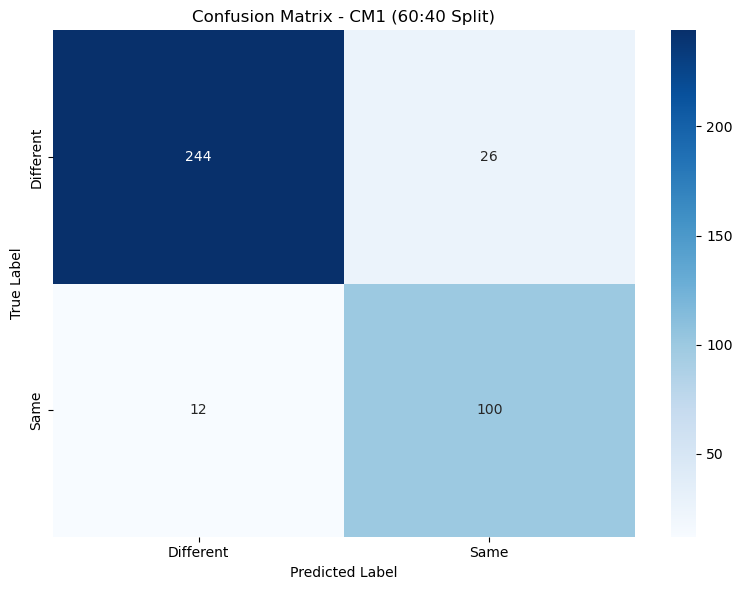

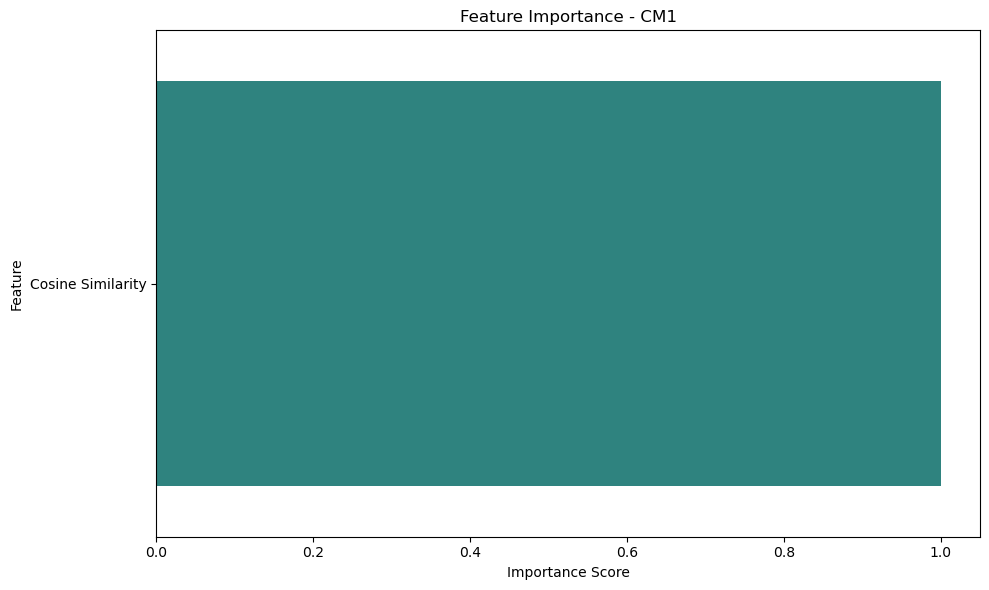


Model, scaler, and results saved!
Files saved with timestamp: 20241111_203917


In [2]:
#CM1 with 60:40 split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Calculate only cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def check_compound_existence(base_path, compound_num):
    """Checks if at least one spectrum file exists for a compound"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

def generate_balanced_comparisons(base_path, debug=False):
    """Creates balanced dataset of spectrum comparisons"""
    X = []  # Features
    y = []  # Labels
    comparisons = []  # File pairs
    same_count = 0    # Count of same-compound pairs
    diff_count = 0    # Count of different-compound pairs
    
    # Find all existing compounds
    existing_compounds = []
    for compound_i in range(1, 29):  # CM1 has 28 compounds
        if check_compound_existence(base_path, compound_i):
            existing_compounds.append(compound_i)
    
    if debug:
        print(f"\nFound {len(existing_compounds)} compounds")
        
    # Generate same-compound comparisons
    for compound_i in existing_compounds:
        if debug:
            print(f"Processing same-compound comparisons for compound {compound_i}")
            
        # Compare first 5 spectra of each compound
        for i in range(1, 5):
            for j in range(i + 1, 6):
                file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                
                if not os.path.exists(file1) or not os.path.exists(file2):
                    continue
                    
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((file1, file2))
                    same_count += 1
    
    # Generate different-compound comparisons
    for idx, compound_i in enumerate(existing_compounds[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound_i}")
            
        # Compare with next compound for balance
        compound2 = existing_compounds[idx+1]
        for i in range(1, 6):
            for j in range(1, 6):
                file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                file2 = f"{base_path}/{compound2:02d}-{j:02d}.csv"
                
                if not os.path.exists(file1) or not os.path.exists(file2):
                    continue
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((file1, file2))
                    diff_count += 1
    
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM1
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1'
    
    # Generate dataset
    print("Generating CM1 comparisons using cosine similarity only...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split data into 60% train and 40% test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model with fixed parameters
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - CM1 (60:40 Split)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance - CM1')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save_model(f'cm1_model_cosine_60_40_split_{timestamp}.json')
        joblib.dump(scaler, f'cm1_scaler_60_40_split_{timestamp}.joblib')
        
        # Save results
        results = {
            'cv_scores': cv_scores.tolist(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_score(y_test, y_prob)
        }
        joblib.dump(results, f'cm1_results_60_40_split_{timestamp}.joblib')
        
        print("\nModel, scaler, and results saved!")
        print(f"Files saved with timestamp: {timestamp}")

if __name__ == "__main__":
    main()

In [ ]:
# using the 60:40 ratio for cm1

Generating CM2 comparisons using cosine similarity only...

Found 580 spectra files
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 43
Processing same-compound comparisons for compound 18
Processing same-compound comparisons for compound 30
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 53
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 20
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 51
Processing same-compound comparisons for compound 22
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 41
Processing same-compound comparisons for compound 32
Processing same-compound comparisons for compound 37
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 54
Processing same-com

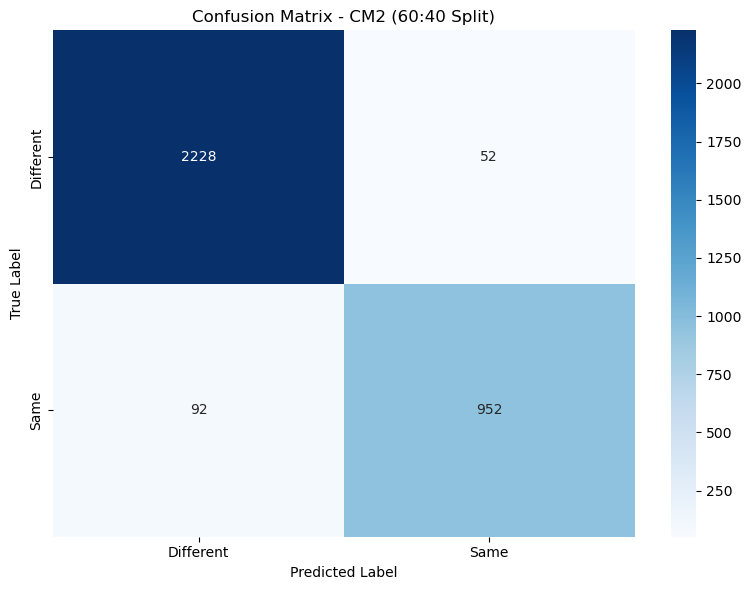

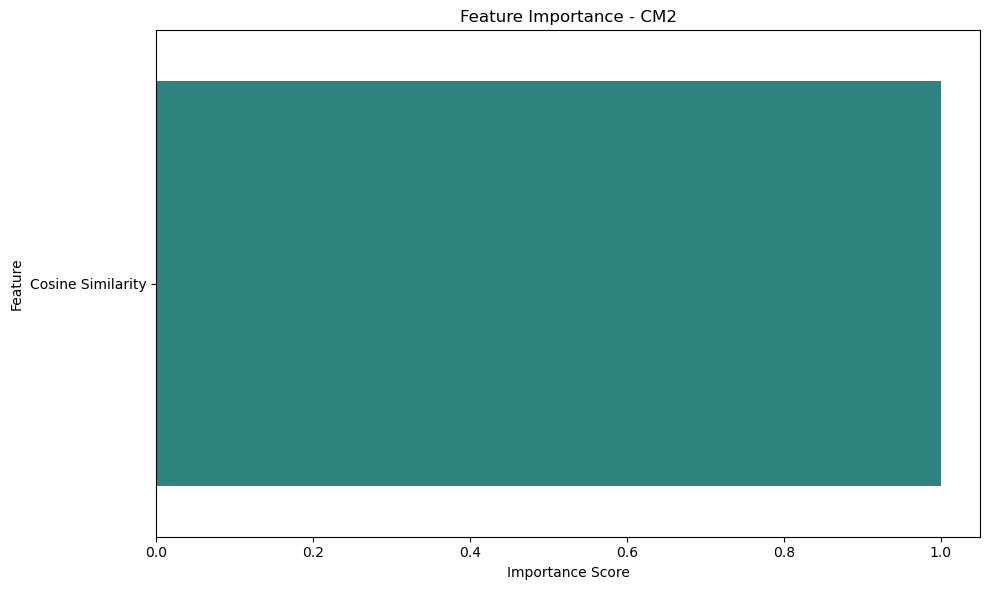


Model, scaler, and results saved!
Files saved with timestamp: 20241111_204121


In [3]:
#CM2 with 60:40 split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Calculate only cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_comparisons(base_path, debug=False):
    """Generate comparison dataset for CM2"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Find all spectra files
    spectra_files = []
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            spectra_files.append(file)
    
    if debug:
        print(f"\nFound {len(spectra_files)} spectra files")
    
    # Group files by compound
    compounds = {}
    for file in spectra_files:
        compound_num = int(file.split('-')[0])
        if compound_num not in compounds:
            compounds[compound_num] = []
        compounds[compound_num].append(file)
    
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((path1, path2))
                    diff_count += 1
    
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM2
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2'
    
    # Generate dataset
    print("Generating CM2 comparisons using cosine similarity only...")
    X, y, comparisons = generate_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split data into 60% train and 40% test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model with fixed parameters
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - CM2 (60:40 Split)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance - CM2')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save_model(f'cm2_model_cosine_60_40_split_{timestamp}.json')
        joblib.dump(scaler, f'cm2_scaler_60_40_split_{timestamp}.joblib')
        
        # Save results
        results = {
            'cv_scores': cv_scores.tolist(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_score(y_test, y_prob)
        }
        joblib.dump(results, f'cm2_results_60_40_split_{timestamp}.joblib')
        
        print("\nModel, scaler, and results saved!")
        print(f"Files saved with timestamp: {timestamp}")

if __name__ == "__main__":
    main()

Generating CM3 comparisons using cosine similarity only...

Found 49 compounds
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 43
Processing same-compound comparisons for compound 18
Processing same-compound comparisons for compound 30
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 20
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 22
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 41
Processing same-compound comparisons for compound 32
Processing same-compound comparisons for compound 37
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 29
Processing same-compound comparisons for compound 25
Processing same-compound comparisons for compound 13
Processing same-compound

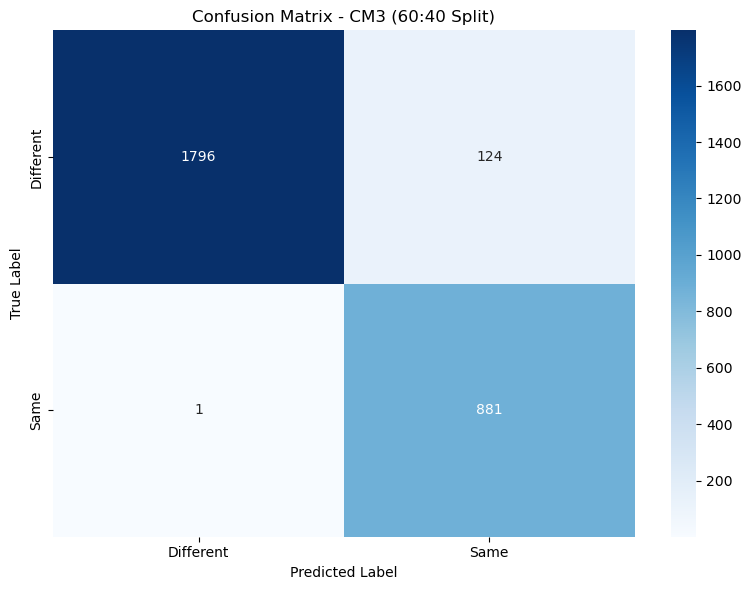

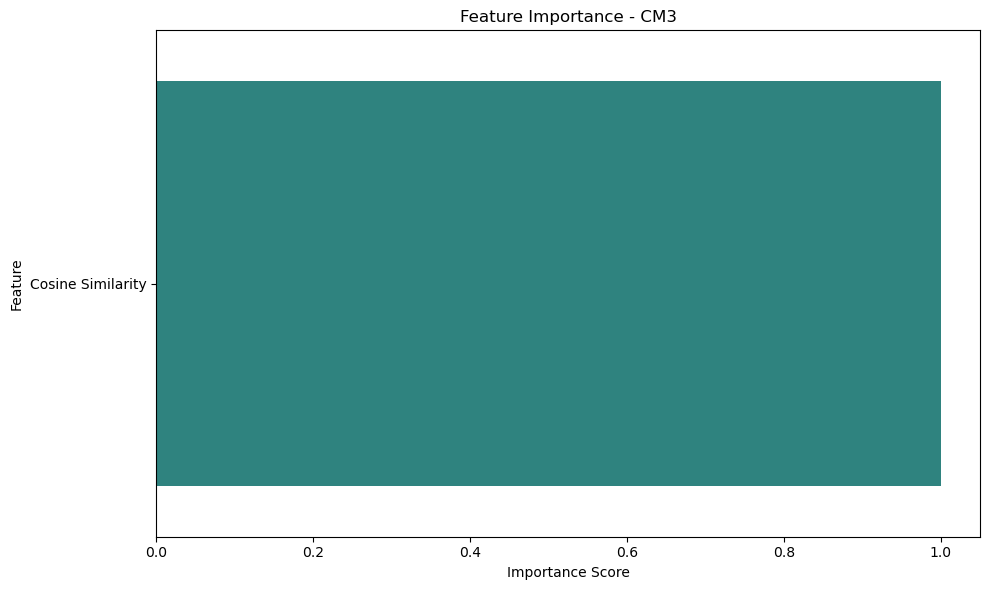


Model, scaler, and results saved!
Files saved with timestamp: 20241111_204455


In [4]:
#CM3 with 60:40 split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra - using only cosine similarity"""
    try:
        # Only calculate cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_balanced_comparisons(base_path, debug=False):
    """Generate balanced comparison dataset for CM3"""
    X = []  # Features
    y = []  # Labels
    comparisons = []  # File pairs
    same_count = 0    # Count of same-compound pairs
    diff_count = 0    # Count of different-compound pairs
    
    # Find all compounds
    compounds = {}
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            compound_num = int(file.split('-')[0])
            if compound_num not in compounds:
                compounds[compound_num] = []
            compounds[compound_num].append(file)
    
    if debug:
        print(f"\nFound {len(compounds)} compounds")
            
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((path1, path2))
                    diff_count += 1
    
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM3
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    
    # Generate comparisons
    print("Generating CM3 comparisons using cosine similarity only...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split data into 60% train and 40% test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model with fixed parameters
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - CM3 (60:40 Split)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance - CM3')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save_model(f'cm3_model_cosine_60_40_split_{timestamp}.json')
        joblib.dump(scaler, f'cm3_scaler_60_40_split_{timestamp}.joblib')
        
        # Save results
        results = {
            'cv_scores': cv_scores.tolist(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_score(y_test, y_prob)
        }
        joblib.dump(results, f'cm3_results_60_40_split_{timestamp}.joblib')
        
        print("\nModel, scaler, and results saved!")
        print(f"Files saved with timestamp: {timestamp}")

if __name__ == "__main__":
    main()

Generating combined comparisons using cosine similarity only...

Processing CM1...

Found 280 spectra files for CM1
Processing same-compound comparisons for CM1 compound 16
Processing same-compound comparisons for CM1 compound 18
Processing same-compound comparisons for CM1 compound 6
Processing same-compound comparisons for CM1 compound 8
Processing same-compound comparisons for CM1 compound 20
Processing same-compound comparisons for CM1 compound 4
Processing same-compound comparisons for CM1 compound 22
Processing same-compound comparisons for CM1 compound 14
Processing same-compound comparisons for CM1 compound 1
Processing same-compound comparisons for CM1 compound 25
Processing same-compound comparisons for CM1 compound 13
Processing same-compound comparisons for CM1 compound 11
Processing same-compound comparisons for CM1 compound 27
Processing same-compound comparisons for CM1 compound 3
Processing same-compound comparisons for CM1 compound 2
Processing same-compound comparison

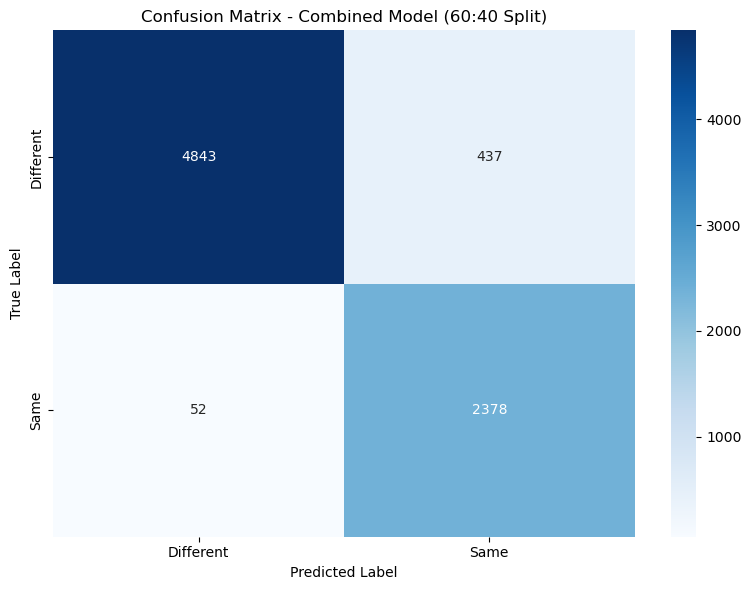

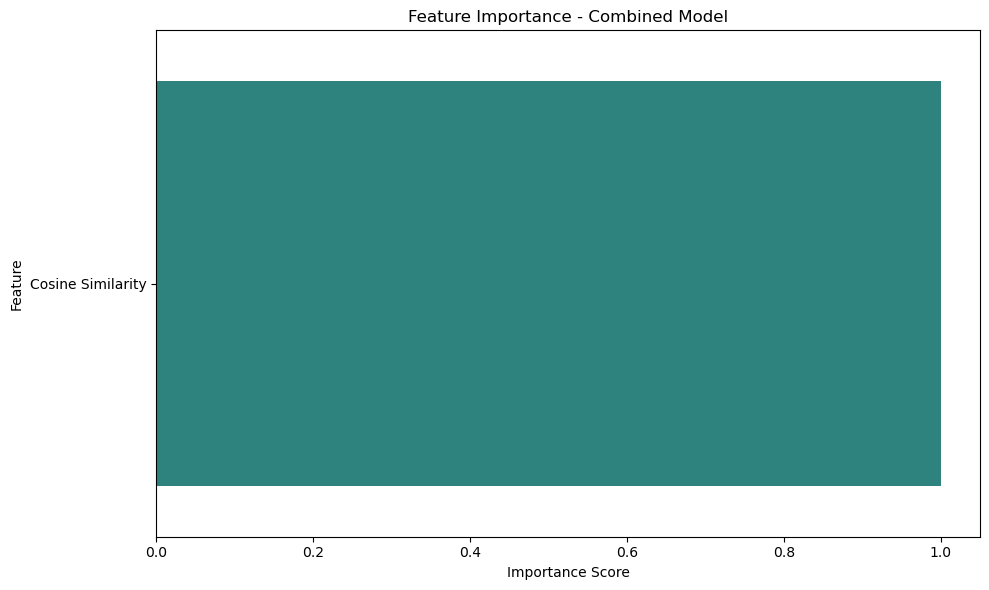


Model, scaler, and results saved!
Files saved with timestamp: 20241111_204713


In [5]:
#Combined Model for CM1, CM2, and CM3 with 60:40 split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate cosine similarity between aligned spectra"""
    try:
        # Calculate only cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        features = {
            'cosine_similarity': cosine_sim,
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def generate_dataset_comparisons(base_path, dataset_name, debug=False):
    """Generate comparisons for a specific dataset"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Find all spectra files
    spectra_files = []
    for file in os.listdir(base_path):
        if file.endswith('.csv'):
            spectra_files.append(file)
    
    if debug:
        print(f"\nFound {len(spectra_files)} spectra files for {dataset_name}")
    
    # Group files by compound
    compounds = {}
    for file in spectra_files:
        compound_num = int(file.split('-')[0])
        if compound_num not in compounds:
            compounds[compound_num] = []
        compounds[compound_num].append(file)
    
    # Generate same-compound comparisons
    for compound in compounds:
        files = compounds[compound]
        if debug:
            print(f"Processing same-compound comparisons for {dataset_name} compound {compound}")
            
        for i, file1 in enumerate(files[:-1]):
            for file2 in files[i+1:]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((dataset_name, path1, path2))
                    same_count += 1
    
    # Generate different-compound comparisons
    compounds_list = list(compounds.keys())
    for i, compound1 in enumerate(compounds_list[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for {dataset_name} compound {compound1}")
            
        # Compare with next compound for balance
        compound2 = compounds_list[i+1]
        for file1 in compounds[compound1]:
            for file2 in compounds[compound2]:
                path1 = os.path.join(base_path, file1)
                path2 = os.path.join(base_path, file2)
                
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(path1), *load_spectrum(path2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(0)  # Different compounds
                    comparisons.append((dataset_name, path1, path2))
                    diff_count += 1
    
    print(f"\n{dataset_name} Comparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    if diff_count > 0:
        print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def main():
    # Base directory containing all datasets
    base_dir = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity'
    
    # Paths for each dataset
    paths = {
        'CM1': os.path.join(base_dir, 'CM1'),
        'CM2': os.path.join(base_dir, 'CM2'),
        'CM3': os.path.join(base_dir, 'CM3')
    }
    
    # Generate combined dataset
    print("Generating combined comparisons using cosine similarity only...")
    
    X_all = []
    y_all = []
    comparisons_all = []
    
    for dataset_name, path in paths.items():
        print(f"\nProcessing {dataset_name}...")
        X, y, comparisons = generate_dataset_comparisons(path, dataset_name, debug=True)
        if len(X) > 0:
            X_all.extend(X)
            y_all.extend(y)
            comparisons_all.extend(comparisons)
    
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    print("\nTotal Dataset Statistics:")
    print(f"Total comparisons: {len(X_all)}")
    print(f"Same compound comparisons: {sum(y_all == 1)}")
    print(f"Different compound comparisons: {sum(y_all == 0)}")
    print(f"Overall class balance ratio: {sum(y_all == 1)/sum(y_all == 0):.2f}")
    
    if len(X_all) > 0:
        # Split data into 60% train and 40% test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.4, random_state=42, stratify=y_all
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model with fixed parameters
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different', 'Same'],
                    yticklabels=['Different', 'Same'])
        plt.title('Confusion Matrix - Combined Model (60:40 Split)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': ['Cosine Similarity'],
            'Importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance - Combined Model')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Save model and scaler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model.save_model(f'combined_model_cosine_60_40_split_{timestamp}.json')
        joblib.dump(scaler, f'combined_scaler_60_40_split_{timestamp}.joblib')
        
        # Save results
        results = {
            'cv_scores': cv_scores.tolist(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_score(y_test, y_prob),
            'dataset_stats': {
                'total_comparisons': len(X_all),
                'same_compound': int(sum(y_all == 1)),
                'different_compound': int(sum(y_all == 0)),
                'balance_ratio': float(sum(y_all == 1)/sum(y_all == 0))
            }
        }
        joblib.dump(results, f'combined_results_60_40_split_{timestamp}.joblib')
        
        print("\nModel, scaler, and results saved!")
        print(f"Files saved with timestamp: {timestamp}")

if __name__ == "__main__":
    main()

In [2]:
import os

# Change directory to the desired folder
os.chdir('/Users/ajibolaoluwatobiloba/Desktop/Mass spectra paper/RESULTS')

# Verify the new working directory
print("Current working directory:", os.getcwd())


Current working directory: /Users/ajibolaoluwatobiloba/Desktop/Mass spectra paper/RESULTS


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_performance_comparison():
    # Model performance data
    data = {
        'Model': ['CM1', 'CM2', 'CM3', 'Combined']*4,
        'Metric': ['Accuracy']*4 + ['ROC AUC']*4 + 
                 ['Precision']*4 + ['Recall']*4,
        'Value': [0.9005, 0.9567, 0.9554, 0.9366,  # Accuracy
                 0.9835, 0.9938, 0.9913, 0.9861,  # ROC AUC
                 0.79, 0.95, 0.88, 0.84,  # Precision (Same class)
                 0.89, 0.91, 1.00, 0.98]  # Recall (Same class)
    }
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Model', y='Value', hue='Metric')
    plt.title('Model Performance Comparison (60:40 Split)', fontsize=14)
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.savefig('performance_comparison_60_40.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_class_distribution():
    data = {
        'Dataset': ['CM1']*2 + ['CM2']*2 + ['CM3']*2 + ['Combined']*2,
        'Class': ['Same', 'Different']*4,
        'Count': [280, 675, 2610, 5700, 2205, 4800, 6075, 13200]
    }
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Dataset', y='Count', hue='Class')
    plt.title('Class Distribution Across Datasets', fontsize=14)
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('class_distribution_60_40.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_cv_scores():
    cv_data = {
        'CM1': [0.96521739, 0.93913043, 0.93913043, 0.92105263, 0.90350877],
        'CM2': [0.96893788, 0.95887663, 0.96589769, 0.95285858, 0.9669007],
        'CM3': [0.95362663, 0.95719382, 0.95243757, 0.9547619, 0.95238095],
        'Combined': [0.9355815, 0.94725465, 0.93731085, 0.9355815, 0.94811933]
    }
    
    plt.figure(figsize=(10, 6))
    data = pd.DataFrame(cv_data)
    sns.boxplot(data=data)
    plt.title('Cross-validation Score Distribution (60:40 Split)', fontsize=14)
    plt.ylabel('CV Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('cv_scores_60_40.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_confusion_matrices():
    cms = {
        'CM1': np.array([[243, 27], [12, 100]]),
        'CM2': np.array([[2234, 46], [94, 950]]),
        'CM3': np.array([[1805, 115], [0, 882]]),
        'Combined': np.array([[4858, 422], [49, 2381]])
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    for (title, cm), ax in zip(cms.items(), axes.ravel()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Different', 'Same'],
                   yticklabels=['Different', 'Same'])
        ax.set_title(f'{title} Confusion Matrix\n(60:40 Split)', fontsize=14)
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_60_40.png', dpi=300, bbox_inches='tight')
    plt.close()

def generate_all_plots():
    plot_performance_comparison()
    plot_class_distribution()
    plot_cv_scores()
    plot_confusion_matrices()

if __name__ == "__main__":
    generate_all_plots()

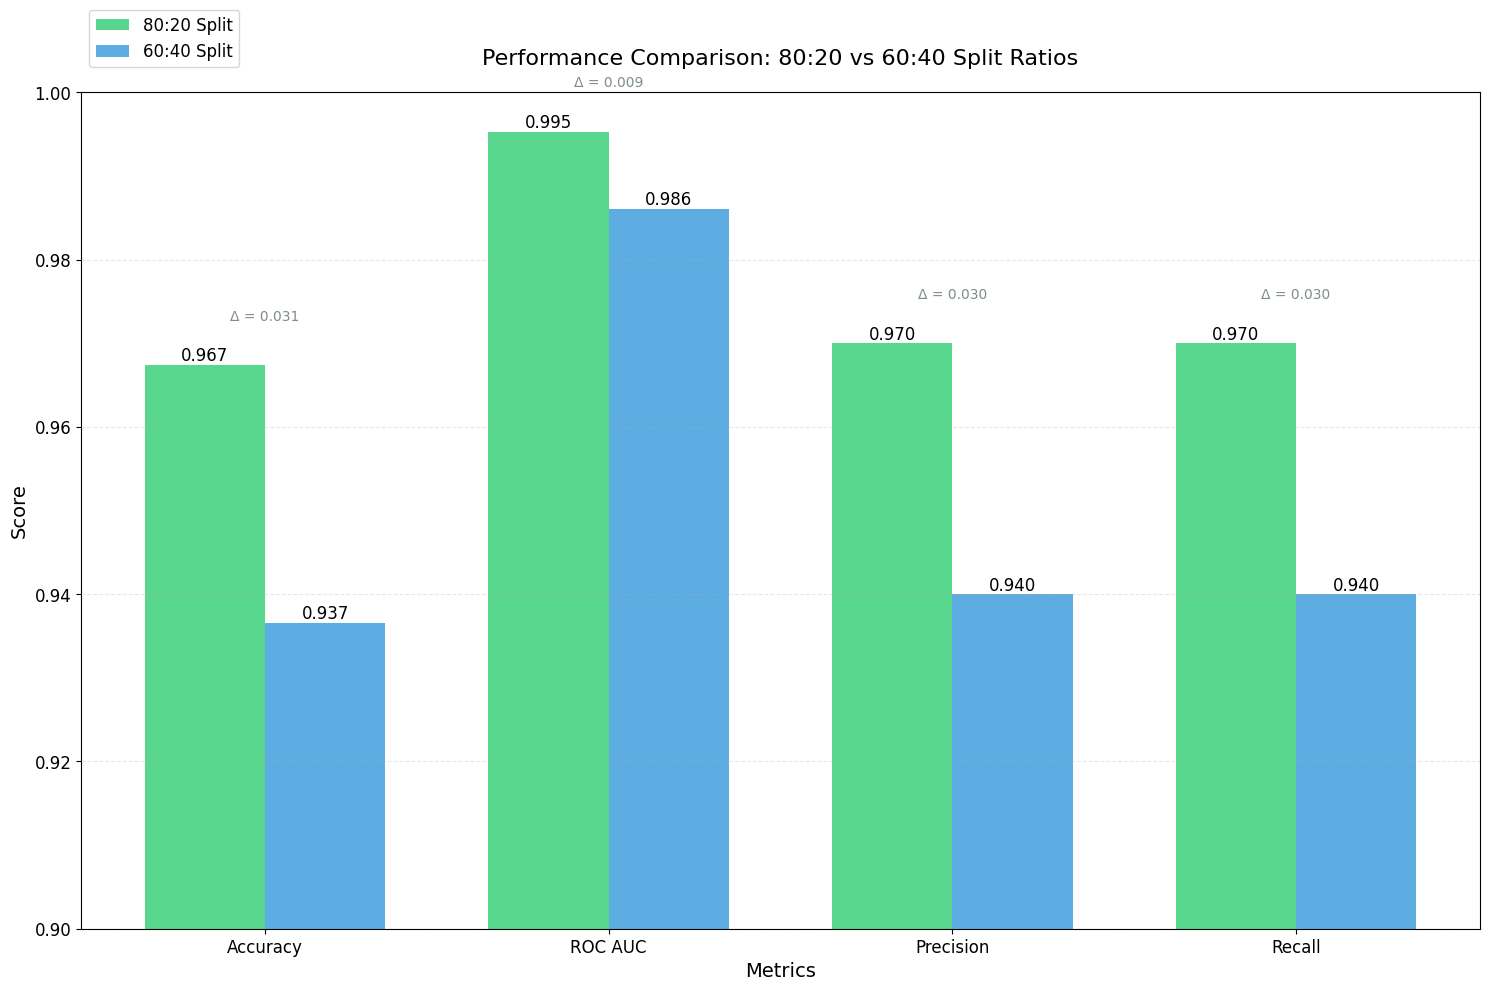

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def create_performance_comparison():
    # Performance metrics with correct values
    metrics = ['Accuracy', 'ROC AUC', 'Precision', 'Recall']
    split_80_20 = [0.9674, 0.9953, 0.97, 0.97]
    split_60_40 = [0.9366, 0.9861, 0.94, 0.94]
    
    # Create figure with larger size
    plt.figure(figsize=(15, 10))
    
    # Set up bar positions
    x = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, split_80_20, width, label='80:20 Split', color='#2ecc71', alpha=0.8)
    plt.bar(x + width/2, split_60_40, width, label='60:40 Split', color='#3498db', alpha=0.8)
    
    # Customize plot
    plt.title('Performance Comparison: 80:20 vs 60:40 Split Ratios', fontsize=16, pad=20)
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(x, metrics, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add value labels on bars
    for i in x:
        plt.text(i - width/2, split_80_20[i], f'{split_80_20[i]:.3f}', 
                ha='center', va='bottom', fontsize=12)
        plt.text(i + width/2, split_60_40[i], f'{split_60_40[i]:.3f}', 
                ha='center', va='bottom', fontsize=12)
    
    # Adjust styling
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.ylim(0.90, 1.0)  # Adjusted y-axis range to better show differences
    plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0.0, 1.02))
    
    # Add difference annotations
    for i in x:
        diff = split_80_20[i] - split_60_40[i]
        plt.text(i, max(split_80_20[i], split_60_40[i]) + 0.005,
                f'Δ = {diff:.3f}',
                ha='center', va='bottom', fontsize=10, color='#7f8c8d')
    
    # Save and show plot
    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'split_ratio_comparison_{timestamp}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_performance_comparison()